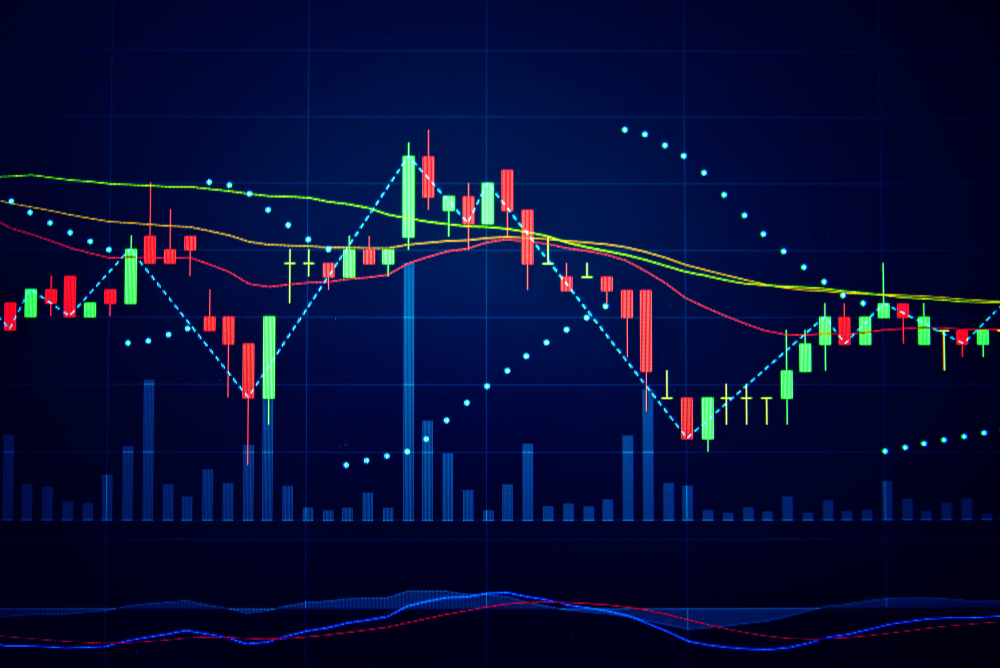

# Introducción al Análisis Técnico

El **análisis técnico** es un enfoque utilizado para evaluar activos financieros mediante el estudio de datos de mercado, principalmente **precios** y **volúmenes** históricos. A diferencia del análisis fundamental, que se enfoca en el valor intrínseco de los activos, el análisis técnico asume que toda la información relevante ya está reflejada en el precio y que los patrones históricos tienden a repetirse.

Este cuaderno aplica análisis técnico sobre la acción de **Apple Inc. (AAPL)** mediante indicadores cuantitativos clásicos, para evaluar puntos de entrada y salida, y posteriormente validar su rendimiento mediante **backtesting** y **optimización**.

---

##  Indicadores Técnicos Utilizados

A continuación, se describen los indicadores y conceptos clave que implementamos:

---

### 1. Media Móvil Simple (SMA)

La **SMA** suaviza la serie de precios calculando el promedio aritmético de los precios de cierre de un activo durante un número determinado de periodos. Es útil para identificar tendencias de mediano a largo plazo.

**Fórmula:**
$$
\
\text{SMA}_n(t) = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}
\
$$
Donde:

- $ \text{SMA}_n(t) $ es la media móvil en el tiempo $ t $ con ventana de tamaño $ n $
- $ P_{t-i} $ es el precio de cierre en el instante $ t - i $

---

### 2. Media Móvil Exponencial (EMA)

La **EMA** da más peso a los precios recientes, lo que la hace más reactiva a cambios recientes en el precio. Se calcula de forma recursiva.

**Fórmula:**
$$
\
\text{EMA}_t = \alpha \cdot P_t + (1 - \alpha) \cdot \text{EMA}_{t-1}
\quad \text{con} \quad \alpha = \frac{2}{n + 1}
\
$$
Donde $ \alpha $ es el factor de suavización y $ n $ es el número de periodos.

---

### 3. Relative Strength Index (RSI)

El **RSI** es un oscilador que mide la velocidad y el cambio de los movimientos de precio. Se interpreta como señal de **sobrecompra** si > 70 o **sobreventa** si < 30.

**Fórmula:**
$$
\
\text{RSI}_t = 100 - \left( \frac{100}{1 + RS_t} \right)
\quad \text{donde} \quad RS_t = \frac{\text{Media de ganancias}}{\text{Media pérdidas}}
\
$$
---

### 4. Bandas de Bollinger (Bollinger Bands)

Las **Bandas de Bollinger** se construyen alrededor de una media móvil y reflejan niveles de volatilidad. Se componen de:

- Banda superior: $ \text{SMA}_{20} + 2 \cdot \sigma $
- Banda inferior: $ \text{SMA}_{20} - 2 \cdot \sigma $

donde $ \sigma $ es la desviación estándar de los precios de cierre en 20 periodos.

---

### 5. Average True Range (ATR)

El **ATR** mide la volatilidad considerando los gaps entre días y la amplitud del rango de precios.

**True Range (TR):**
$$
\
TR = \max \left(
\text{High} - \text{Low},\,
|\text{High} - \text{Close}_{\text{prev}}|,\,
|\text{Low} - \text{Close}_{\text{prev}}|
\right)
\
$$
**ATR (promedio de los TR):**
$$
\
\text{ATR}_t = \text{Media móvil de } TR \text{ en } n \text{ periodos}
\
$$
---

## 📈 Objetivo del proyecto

Con estos indicadores implementamos una estrategia simple basada en condiciones del RSI y cruces entre EMA y SMA para generar señales de compra y venta. Esta estrategia se valida mediante backtesting y se mejora a través de un proceso de optimización de parámetros.



In [1]:
#!pip install yfinance --upgrade
#!pip install ta
#!pip install backtesting
#!pip install --upgrade plotly==5.20.0
#!pip install mplfinance
#!pip install pandas_ta==0.3.14b0
#!pip install numpy==1.24.3


In [2]:
import yfinance as yf
import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import plotly.graph_objects as go
import mplfinance as mpf
import pandas_ta as pdta
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
#
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'
#


/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [3]:
#  Apple Stocks
aapl = yf.download('AAPL',auto_adjust=False, start = '2021-01-01', end = '2025-04-30').dropna()

[*********************100%***********************]  1 of 1 completed


In [4]:
aapl

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2021-01-04,126.239708,129.410004,133.610001,126.760002,133.520004,143301900
2021-01-05,127.800476,131.009995,131.740005,128.429993,128.889999,97664900
2021-01-06,123.498512,126.599998,131.050003,126.379997,127.720001,155088000
2021-01-07,127.712730,130.919998,131.630005,127.860001,128.360001,109578200
2021-01-08,128.815018,132.050003,132.630005,130.229996,132.429993,105158200
...,...,...,...,...,...,...
2025-04-23,204.332062,204.600006,208.000000,202.800003,206.000000,52929200
2025-04-24,208.097107,208.369995,208.830002,202.940002,204.889999,47311000


In [5]:
aapl.dtypes

,,0
Price,Ticker,
Adj Close,AAPL,float64
Close,AAPL,float64
High,AAPL,float64
Low,AAPL,float64
Open,AAPL,float64
Volume,AAPL,int64


In [6]:


import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'

# Descargar datos válidos
aapl = yf.download('AAPL', auto_adjust=False, start='2025-01-01', end='2025-04-30').dropna()
aapl.columns = aapl.columns.droplevel(1)

# Gráfico con subplots
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    row_heights=[0.7, 0.3], subplot_titles=("Precio AAPL 2025", "Volumen")
)

# Velas japonesas
fig.add_trace(go.Candlestick(
    x=aapl.index,
    open=aapl['Open'],
    high=aapl['High'],
    low=aapl['Low'],
    close=aapl['Adj Close'],
    name='Velas',
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)

# Volumen
fig.add_trace(go.Bar(
    x=aapl.index,
    y=aapl['Volume'],
    name='Volumen',
    marker_color='white',
    opacity=0.5
), row=2, col=1)

# Layout final
fig.update_layout(
    title='AAPL - Gráfico de Velas + Volumen',
    xaxis_rangeslider_visible=False,
    height=700,
    template='plotly_dark'
)

fig.add_annotation(text='Apple (AAPL)',
                    font=dict(color='white', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)
fig.show()


[*********************100%***********************]  1 of 1 completed


In [7]:

# Descargar datos
aapl = yf.download('AAPL', auto_adjust=False, start='2021-01-01', end='2025-04-30').dropna()
aapl.columns = aapl.columns.droplevel(1)

# Gráfico con subplots
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    row_heights=[0.7, 0.3], subplot_titles=("Precio AAPL 2021-2025", "Volumen")
)

# Velas japonesas
fig.add_trace(go.Candlestick(
    x=aapl.index,
    open=aapl['Open'],
    high=aapl['High'],
    low=aapl['Low'],
    close=aapl['Adj Close'],
    name='Velas',
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)

# Volumen
fig.add_trace(go.Bar(
    x=aapl.index,
    y=aapl['Volume'],
    name='Volumen',
    marker_color='white',
    opacity=0.5
), row=2, col=1)

# Layout final
fig.update_layout(
    title='AAPL - Gráfico de Velas + Volumen',
    xaxis_rangeslider_visible=False,
    height=700,
    template='plotly_dark'
)

fig.add_annotation(text='Apple (AAPL)',
                    font=dict(color='white', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)
fig.show()


[*********************100%***********************]  1 of 1 completed


#Lógica de la Estrategia de Trading

La estrategia implementada en este proyecto combina dos enfoques del análisis técnico:

1. **Momentum** a través del RSI (Relative Strength Index)
2. **Tendencia** mediante un cruce de medias móviles (EMA y SMA)

Esta combinación busca generar señales de compra cuando el activo se encuentra en una zona de sobreventa y comienza una recuperación (cruce alcista de medias), y salir cuando hay señales de agotamiento (sobrecompra o cruce bajista).

---

### Reglas de entrada y salida

####  Entrada (se abre una posición larga):

- $ \text{RSI}_t < 30 $  → el activo está en sobreventa
- $ \text{EMA}_t > \text{SMA}_t $ y hay un **cruce alcista**:  
  $ \text{EMA}_{t-1} \leq \text{SMA}_{t-1} $

####  Salida (se cierra la posición):

- $ \text{RSI}_t > 70 $  → el activo está en sobrecompra  
**o**
- Hay un **cruce bajista**:  
  $ \text{EMA}_{t-1} \geq \text{SMA}_{t-1} $ y $ \text{EMA}_t < \text{SMA}_t $

---

### Pseudocódigo

```python
if RSI < 30 and crossover(EMA, SMA):
    buy()

if RSI > 70 or crossover(SMA, EMA):
    sell()


In [8]:

# Medias Móviles
aapl['EMA9'] = aapl['Adj Close'].ewm(span = 9, adjust = False).mean() # Media Móvil Exponencial 9- periodos
aapl['SMA20'] = aapl['Adj Close'].rolling(window=20).mean() #Media movil simple 20 periodos
aapl['SMA50'] = aapl['Adj Close'].rolling(window=50).mean() #Media movil simple 50 periodos
aapl['SMA100'] = aapl['Adj Close'].rolling(window=100).mean() #Media movil simple 100 periodos
aapl['SMA200'] = aapl['Adj Close'].rolling(window=200).mean() #Media movil simple 200 periodos

# RSI para 14 periodos
delta = aapl['Adj Close'].diff() #  delta
gain = delta.where(delta > 0,0) # Ganancias
loss = -delta.where(delta < 0,0) # Pérdidas
avg_gain = gain.rolling(window=14).mean() # Promedio de ganancias 14 días
avg_loss = loss.rolling(window=14).mean() # Promedio de pérdidas 14 días
rs = avg_gain/avg_loss # RS
aapl['RSI'] = 100 - (100 / (1 + rs)) #Creamos la columna RSI en el DF

#   Bandas de Bollinger 20 periodos
aapl['BB_UPPER'] = aapl['SMA20'] + 2*aapl['Adj Close'].rolling(window=20).std() # Upper Band
aapl['BB_LOWER'] = aapl['SMA20'] - 2*aapl['Adj Close'].rolling(window=20).std() # Lower Band

#  ATR 14-periodos
aapl['TR'] = pd.DataFrame(np.maximum(np.maximum(aapl['High'] - aapl['Low'], abs(aapl['High'] - aapl['Adj Close'].shift())), abs(aapl['Low'] - aapl['Adj Close'].shift())), index = aapl.index)
aapl['ATR'] = aapl['TR'].rolling(window = 14).mean() #Agregando columna ART al Data Frame

In [9]:
aapl.tail(30)

Price,Adj Close,Close,High,Low,Open,Volume,EMA9,SMA20,SMA50,SMA100,SMA200,RSI,BB_UPPER,BB_LOWER,TR,ATR
Date,,,,,,,,,,,,,,,,
2025-03-18,212.411453,212.690002,215.149994,211.490005,214.160004,42432400,219.486702,232.153066,233.149408,235.131271,227.290467,23.832040,258.157240,206.148893,3.659988,7.300972
2025-03-19,214.958115,215.240005,218.759995,213.750000,214.220001,54385400,218.580984,230.673507,232.593083,234.930514,227.413259,28.934298,257.072266,204.274748,6.348541,7.368724
2025-03-20,213.819611,214.100006,217.490005,212.220001,213.990005,48862900,217.628710,229.089085,231.981266,234.769193,227.525582,21.670769,255.542742,202.635428,5.270004,6.895867
2025-03-21,217.984146,218.270004,218.839996,211.279999,211.559998,94127800,217.699797,227.726871,231.508407,234.651411,227.649869,29.967568,253.477741,201.976001,7.559998,6.870153
2025-03-24,220.440918,220.729996,221.479996,218.580002,221.000000,44299500,218.248021,226.410097,231.074906,234.549826,227.784846,34.702090,250.712067,202.108126,3.495850,6.734856
2025-03-25,223.456970,223.750000,224.100006,220.080002,220.770004,34493600,219.289811,225.247122,230.818445,234.458571,227.927340,38.583126,247.605941,202.888303,4.020004,6.499141
2025-03-26,221.239868,221.529999,225.020004,220.470001,223.509995,34466100,219.679822,224.306855,230.566524,234.342455,228.065666,37.297493,245.601763,203.011947,4.550003,6.488427
2025-03-27,223.556839,223.850006,224.990005,220.559998,221.389999,37094800,220.455226,223.635236,230.383289,234.285083,228.203583,35.614369,244.076143,203.194328,4.430008,6.332714
2025-03-28,217.614624,217.899994,223.809998,217.679993,221.669998,39818600,219.887105,222.439803,229.989630,234.210042,228.330551,39.864579,241.203602,203.676005,6.130005,5.732220


#Gráfico completo

In [10]:

# Creamos 4 subplots (precio, RSI, ATR, Volumen)
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True,
    row_heights=[0.45, 0.2, 0.2, 0.15],
    vertical_spacing=0.03,
    subplot_titles=("Precio AAPL con Indicadores Técnicos", "RSI (14)", "ATR (14)", "Volumen")
)

# --- Panel 1: Velas + indicadores ---
fig.add_trace(go.Candlestick(
    x=aapl.index,
    open=aapl['Open'], high=aapl['High'],
    low=aapl['Low'], close=aapl['Close'],
    name='Velas',
    increasing_line_color='green', decreasing_line_color='red'
), row=1, col=1)

# Medias móviles
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['EMA9'], mode='lines', name='EMA9'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA20'], mode='lines', name='SMA20'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA50'], mode='lines', name='SMA50'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA100'], mode='lines', name='SMA100'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA200'], mode='lines', name='SMA200'), row=1, col=1)

# Bollinger Bands
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['BB_UPPER'], mode='lines', name='Bollinger Upper', line=dict(dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['BB_LOWER'], mode='lines', name='Bollinger Lower', line=dict(dash='dot')), row=1, col=1)

# --- Panel 2: RSI ---
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['RSI'], name='RSI', line=dict(color='violet')), row=2, col=1)
fig.add_hline(y=70, line=dict(color='red', width=1, dash='dot'), row=2, col=1)
fig.add_hline(y=30, line=dict(color='green', width=1, dash='dot'), row=2, col=1)

# --- Panel 3: ATR ---
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['ATR'], name='ATR', line=dict(color='cyan')), row=3, col=1)

# --- Panel 4: Volumen ---
fig.add_trace(go.Bar(x=aapl.index, y=aapl['Volume'], name='Volumen', marker_color='white', opacity=0.5), row=4, col=1)

# Layout general
fig.update_layout(
    title='Análisis Técnico Completo de AAPL',
    template='plotly_dark',
    height=1200,
    showlegend=True,
    xaxis_rangeslider_visible=False,
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom")
)

fig.show()


#Ejemplo con señales RSI

In [11]:
# Detección de eventos
rsi_overbought = aapl[aapl['RSI'] > 70]
rsi_oversold = aapl[aapl['RSI'] < 30]

# Añadir puntos al gráfico RSI
fig.add_trace(go.Scatter(
    x=rsi_overbought.index,
    y=rsi_overbought['RSI'],
    mode='markers',
    marker=dict(color='red', size=6, symbol='triangle-up'),
    name='RSI > 70'
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=rsi_oversold.index,
    y=rsi_oversold['RSI'],
    mode='markers',
    marker=dict(color='green', size=6, symbol='triangle-down'),
    name='RSI < 30'
), row=2, col=1)


#Ejemplo: Cruce EMA9 arriba de SMA20 (Golden Cross)

In [12]:
signal = (aapl['EMA9'] > aapl['SMA20']) & (aapl['EMA9'].shift() <= aapl['SMA20'].shift())
cross_up = aapl[signal]

fig.add_trace(go.Scatter(
    x=cross_up.index,
    y=cross_up['Close'],
    mode='markers',
    marker=dict(color='lightblue', size=8, symbol='circle'),
    name='Cruce EMA9>SMA20'
), row=1, col=1)


In [13]:

# Señales visuales
rsi_overbought = aapl[aapl['RSI'] > 70]
rsi_oversold = aapl[aapl['RSI'] < 30]

# Cruce EMA9 > SMA20 (señal de compra)
signal_cross = (aapl['EMA9'] > aapl['SMA20']) & (aapl['EMA9'].shift() <= aapl['SMA20'].shift())
cross_up = aapl[signal_cross]

# --- Crear gráfico con 4 subplots ---
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True,
    row_heights=[0.45, 0.2, 0.2, 0.15],
    vertical_spacing=0.03,
    subplot_titles=("Precio AAPL con Indicadores Técnicos", "RSI (14)", "ATR (14)", "Volumen")
)

# --- Panel 1: Velas + líneas ---
fig.add_trace(go.Candlestick(
    x=aapl.index,
    open=aapl['Open'], high=aapl['High'],
    low=aapl['Low'], close=aapl['Close'],
    name='Velas',
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)

# Medias móviles
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['EMA9'], name='EMA9', mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA20'], name='SMA20', mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA50'], name='SMA50', mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA100'], name='SMA100', mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['SMA200'], name='SMA200', mode='lines'), row=1, col=1)

# Bandas de Bollinger
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['BB_UPPER'], name='Bollinger Upper', mode='lines', line=dict(dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['BB_LOWER'], name='Bollinger Lower', mode='lines', line=dict(dash='dot')), row=1, col=1)

# Alertas: Círculos azules en cruces EMA9 > SMA20
fig.add_trace(go.Scatter(
    x=cross_up.index,
    y=cross_up['Close'],
    mode='markers',
    marker=dict(color='lightblue', size=8, symbol='circle'),
    name='Cruce EMA9 > SMA20'
), row=1, col=1)

# --- Panel 2: RSI ---
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['RSI'], name='RSI', line=dict(color='violet')), row=2, col=1)

# Líneas horizontales RSI
fig.add_hline(y=70, line=dict(color='red', width=1, dash='dot'), row=2, col=1)
fig.add_hline(y=30, line=dict(color='green', width=1, dash='dot'), row=2, col=1)

# Señales RSI
fig.add_trace(go.Scatter(
    x=rsi_overbought.index,
    y=rsi_overbought['RSI'],
    mode='markers',
    marker=dict(color='red', size=6, symbol='triangle-up'),
    name='RSI > 70'
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=rsi_oversold.index,
    y=rsi_oversold['RSI'],
    mode='markers',
    marker=dict(color='green', size=6, symbol='triangle-down'),
    name='RSI < 30'
), row=2, col=1)

# --- Panel 3: ATR ---
fig.add_trace(go.Scatter(x=aapl.index, y=aapl['ATR'], name='ATR', line=dict(color='cyan')), row=3, col=1)

# --- Panel 4: Volumen ---
fig.add_trace(go.Bar(
    x=aapl.index, y=aapl['Volume'],
    name='Volumen', marker_color='orange', opacity=0.5
), row=4, col=1)

# Layout final
fig.update_layout(
    title='AAPL - Análisis Técnico Completo con Alertas Visuales',
    template='plotly_dark',
    height=1200,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom")
)

fig.show()


#Backtesting

In [14]:
!pip install backtesting

Definimos una estrategia simple (basada en nuestros indicadores)
Por ejemplo:


*   Comprar cuando RSI < 30 y EMA9 cruza por encima de SMA20.
*   Vender cuando RSI > 70 o EMA9 cruza por debajo de SMA20



In [15]:


# Crear nuevo DataFrame compatible con backtesting.py
bt_data = aapl[['Open', 'High', 'Low', 'Adj Close', 'Volume']].copy()
bt_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']  # backtesting.py exige estas columnas

# Clase de estrategia
class EMARSI_Strategy(Strategy):
    def init(self):
    # Base
        close = self.data.Close

        # Corregimos usando pd.Series en las funciones
        self.ema9 = self.I(lambda x: pd.Series(x).ewm(span=9).mean(), close)
        self.sma20 = self.I(lambda x: pd.Series(x).rolling(window=20).mean(), close)

        # RSI corregido también
        def calc_rsi(x, period=14):
            x = pd.Series(x)
            delta = x.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            avg_gain = gain.rolling(window=period).mean()
            avg_loss = loss.rolling(window=period).mean()
            rs = avg_gain / avg_loss
            return 100 - (100 / (1 + rs))

        self.rsi = self.I(calc_rsi, close)


    def next(self):
        if (
            self.rsi[-1] < 30 and
            crossover(self.ema9, self.sma20)
        ):
            self.buy()

        elif (
            self.rsi[-1] > 70 or
            crossover(self.sma20, self.ema9)
        ):
            self.position.close()


In [16]:
bt = Backtest(bt_data, EMARSI_Strategy, cash=10000, commission=0.002)
result = bt.run()
bt.plot()


Backtest.run:   0%|          | 0/1065 [00:00<?, ?bar/s]

GridPlot(id='p1229', ...)

#Clase de estrategia optimizable

In [17]:
from backtesting import Strategy
from backtesting.lib import crossover
import pandas as pd

class EMARSI_OptStrategy(Strategy):
    # Parámetros optimizables (valores por defecto)
    rsi_period = 14
    ema_span = 9
    sma_window = 20

    def init(self):
        close = self.data.Close

        # EMA y SMA
        self.ema = self.I(lambda x: pd.Series(x).ewm(span=self.ema_span).mean(), close)
        self.sma = self.I(lambda x: pd.Series(x).rolling(window=self.sma_window).mean(), close)

        # RSI
        def calc_rsi(x):
            x = pd.Series(x)
            delta = x.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            avg_gain = gain.rolling(window=self.rsi_period).mean()
            avg_loss = loss.rolling(window=self.rsi_period).mean()
            rs = avg_gain / avg_loss
            return 100 - (100 / (1 + rs))

        self.rsi = self.I(calc_rsi, close)

    def next(self):
        if (
            self.rsi[-1] < 30 and
            crossover(self.ema, self.sma)
        ):
            self.buy()

        elif (
            self.rsi[-1] > 70 or
            crossover(self.sma, self.ema)
        ):
            self.position.close()


#Ejecutar la optimización

In [18]:
from backtesting import Backtest

#  'bt_data' definido como antes
bt = Backtest(bt_data, EMARSI_OptStrategy, cash=10000, commission=0.002)

# optimización
result = bt.optimize(
    rsi_period=range(10, 25, 2),
    ema_span=range(5, 15),
    sma_window=range(15, 31, 5),
    maximize='Sharpe Ratio',  # También puedemos usar 'Return [%]'
    constraint=lambda param: param.ema_span < param.sma_window  # Lógica válida
)

# Ver resultados óptimos
print(result)

# Graficar con los mejores parámetros encontrados así:
bt.plot()


/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1606: UserWarning:

Searching for best of 320 configurations.



Backtest.optimize:   0%|          | 0/320 [00:00<?, ?it/s]

Backtest.run:   0%|          | 0/1069 [00:00<?, ?bar/s]

Start                     2021-01-04 00:00:00
End                       2025-04-29 00:00:00
Duration                   1576 days 00:00:00
Exposure Time [%]                     1.10599
Equity Final [$]                  10078.19059
Equity Peak [$]                   10578.94875
Commissions [$]                      39.96944
Return [%]                            0.78191
Buy & Hold Return [%]                51.04119
Return (Ann.) [%]                     0.18106
Volatility (Ann.) [%]                 2.74573
CAGR [%]                              0.12462
Sharpe Ratio                          0.06594
Sortino Ratio                         0.08135
Calmar Ratio                          0.02842
Alpha [%]                             0.33509
Beta                                  0.00875
Max. Drawdown [%]                    -6.37124
Avg. Drawdown [%]                    -3.36944
Max. Drawdown Duration      602 days 00:00:00
Avg. Drawdown Duration      303 days 00:00:00
# Trades                          

GridPlot(id='p1647', ...)

heatmap de Sharpe Ratio cruzando dos variables clave:

ema_span en el eje X (EMA rápida)

sma_window en el eje Y (SMA lenta)

# Conclusiones y Recomendaciones

Este proyecto demuestra cómo aplicar herramientas del análisis técnico clásico sobre datos reales para construir, validar y optimizar una estrategia de trading sistemática.

## Principales aprendizajes:

- Se implementaron y visualizaron indicadores clave como **SMA**,, **EMA**, **RSI**, **Bandas de Bollinger** y **ATR**, comprendiendo su interpretación y cálculo matemático.
- Se construyó una estrategia de trading basada en reglas simples pero efectivas: **sobreventa + cruce alcista para comprar**, y **sobrecompra o cruce bajista para salir**.
- Se utilizó la librería `backtesting.py` para realizar pruebas retrospectivas (**backtesting**) sobre datos históricos de AAPL.
- Mediante `bt.optimize()` se identificaron las combinaciones de parámetros que maximizan el desempeño, en particular el **Sharpe Ratio**, que mide el retorno ajustado por riesgo.

---

## Fortalezas de la estrategia:

- **Clara y replicable**: fácil de entender, auditar y ajustar
- **Basada en lógica económica**: entrada en zonas de sobreventa con confirmación de tendencia
- **Mejorada con optimización sistemática**: es decir sin necesidad de ajuste manual de parámetros

---




